### Autenticação e Configuração do Projeto

Neste trecho de código, estamos realizando a autenticação para acessar os serviços do Google Cloud e configurando o cliente do BigQuery para interagir com o banco de dados do BigQuery.

1. **Autenticação:**
   A função `auth.authenticate_user()` é utilizada para autenticar o usuário e permitir o acesso aos recursos do Google Cloud.

2. **Configuração do Cliente BigQuery:**
   O cliente BigQuery (`bigquery.Client()`) é configurado para permitir que o código execute consultas e manipule dados no BigQuery.

Com isso, o ambiente está pronto para trabalhar com dados no BigQuery a partir deste notebook.


# 0.0 Preparando o Ambiente


In [3]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client()


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import warnings

warnings.filterwarnings("ignore")

In [5]:
pip install findspark

#### Neste bloco, inicializamos o ambiente Spark para utilizar a API SQL que o framework disponibiliza. Essa abordagem simplifica a sintaxe e otimiza o processamento das informações, tornando o trabalho com dados mais eficiente.

In [6]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [7]:
from pyspark.sql import Row, dataframe
from pyspark.sql.types import StructField, StructType, StringType, IntegerType
from pyspark.sql.functions import col, expr, lit, substring, concat, concat_ws, when, coalesce
from pyspark.sql import functions as f
from functools import reduce

# 1.0 Dimensões

Criamos tabelas de dimensões com base no dicionário de dados disponibilizado para facilitar a interpretação e análise dos dados da PNAD-COVID-19. Essas tabelas ajudam a transformar códigos numéricos em descrições mais legíveis, promovendo maior clareza nas análises.

### Dimensão Teste Covid

In [8]:
data_covid = [
    (1, "Positivo"),
    (2, "Negativo"),
    (3, "Inconclusivo"),
    (4, "Ainda não recebeu o resultado"),
    (9, "Ignorado"),
    (10, "Não aplicável")
]

# Criando o DataFrame Spark
depara_teste_covid = spark.createDataFrame(data_covid,["codigo","descricao"])

# Criando uma tabela temporária para consultas SQL
depara_teste_covid.createOrReplaceTempView("depara_teste_covid")

### Dimensão UF

In [9]:
data_estados = [
    (11, "Rondônia"), (12, "Acre"), (13, "Amazonas"), (14, "Roraima"),
    (15, "Pará"), (16, "Amapá"), (17, "Tocantins"), (21, "Maranhão"),
    (22, "Piauí"), (23, "Ceará"), (24, "Rio Grande do Norte"), (25, "Paraíba"),
    (26, "Pernambuco"), (27, "Alagoas"), (28, "Sergipe"), (29, "Bahia"),
    (31, "Minas Gerais"), (32, "Espírito Santo"), (33, "Rio de Janeiro"),
    (35, "São Paulo"), (41, "Paraná"), (42, "Santa Catarina"),
    (43, "Rio Grande do Sul"), (50, "Mato Grosso do Sul"), (51, "Mato Grosso"),
    (52, "Goiás"), (53, "Distrito Federal")
]

# Criando o DataFrame Spark
depara_estados = spark.createDataFrame(data_estados, ["codigo", "estado"])

# Criando uma tabela temporária para consultas SQL
depara_estados.createOrReplaceTempView("depara_uf")

### Dimensão Respostas

In [10]:
data_respostas = [
    (1, "Sim"),
    (2, "Não"),
    (3, "Não sabe"),
    (9, "Ignorado")
]

# Criando o DataFrame Spark
depara_respostas = spark.createDataFrame(data_respostas, ["codigo", "resposta"])

# Criando uma tabela temporária para consultas SQL
depara_respostas.createOrReplaceTempView("depara_resposta")

### Dimensão Escolaridade

In [11]:
data_escolaridade = [
    (1, "Sem instrução"),
    (2, "Fundamental incompleto"),
    (3, "Fundamental completo"),
    (4, "Médio incompleto"),
    (5, "Médio completo"),
    (6, "Superior incompleto"),
    (7, "Superior completo"),
    (8, "Pós-graduação, mestrado ou doutorado")
]

# Criando o DataFrame Spark
depara_escolaridade = spark.createDataFrame(data_escolaridade, ["codigo", "escolaridade"])

# Criando uma tabela temporária para consultas SQL
depara_escolaridade.createOrReplaceTempView("depara_escolaridade")

### Dimensão Atendimento

In [12]:
data_atendimento = [
    (1, "Sim"),
    (2, "Não"),
    (3, "Não foi atendido"),
    (9, "Ignorado")
]

# Criando o DataFrame Spark
depara_atendimento = spark.createDataFrame(data_atendimento, ["codigo", "atendimento"])

# Criando uma tabela temporária para consultas SQL
depara_atendimento.createOrReplaceTempView("depara_atendimento")


### Dimensão Profissão

In [13]:
data_profissoes = [
    (1, "Empregado doméstico, diarista, cozinheiro (em domicílios particulares)"),
    (2, "Faxineiro, auxiliar de limpeza etc. (em empresa pública ou privada)"),
    (3, "Auxiliar de escritório, escriturário"),
    (4, "Secretária, recepcionista"),
    (5, "Operador de Telemarketing"),
    (6, "Comerciante (dono do bar, da loja etc.)"),
    (7, "Balconista, vendedor de loja"),
    (8, "Vendedor a domicílio, representante de vendas, vendedor de catálogo (Avon, Natura etc.)"),
    (9, "Vendedor ambulante (feirante, camelô, comerciante de rua, quiosque)"),
    (10, "Cozinheiro e garçom (de restaurantes, empresas)"),
    (11, "Padeiro, açougueiro e doceiro"),
    (12, "Agricultor, criador de animais, pescador, silvicultor e jardineiro"),
    (13, "Auxiliar da agropecuária (colhedor de frutas, boia fria, etc.)"),
    (14, "Motorista (de aplicativo, de taxi, de van, de mototáxi, de ônibus)"),
    (15, "Motorista de caminhão (caminhoneiro)"),
    (16, "Motoboy"),
    (17, "Entregador de mercadorias (de restaurante, de farmácia, de loja, Uber Eats, iFood, Rappy etc.)"),
    (18, "Pedreiro, servente de pedreiro, pintor, eletricista, marceneiro"),
    (19, "Mecânico de veículos, máquinas industriais etc."),
    (20, "Artesão, costureiro e sapateiro"),
    (21, "Cabeleireiro, manicure e afins"),
    (22, "Operador de máquinas, montador na indústria"),
    (23, "Auxiliar de produção, de carga e descarga"),
    (24, "Professor da educação infantil, de ensino fundamental, médio ou superior"),
    (25, "Pedagogo, professor de idiomas, música, arte e reforço escolar"),
    (26, "Médico, enfermeiro, profissionais de saúde de nível superior"),
    (27, "Técnico, profissional da saúde de nível médio"),
    (28, "Cuidador de crianças, doentes ou idosos"),
    (29, "Segurança, vigilante, outro trabalhador dos serviços de proteção"),
    (30, "Policial civil"),
    (31, "Porteiro, zelador"),
    (32, "Artista, religioso (padre, pastor etc.)"),
    (33, "Diretor, gerente, cargo político ou comissionado"),
    (34, "Outra profissão de nível superior (advogado, engenheiro, contador, jornalista etc.)"),
    (35, "Outro técnico ou profissional de nível médio"),
    (36, "Outros")
]

# Criando o DataFrame Spark
depara_profissoes = spark.createDataFrame(data_profissoes, ["codigo", "profissao"])

# Criando uma tabela temporária para consultas SQL
depara_profissoes.createOrReplaceTempView("depara_profissoes")


### Dimensão Faixa Salarial

In [14]:
data_faixa_salarial = [
    (0, "0 - 100"),
    (1, "101 - 300"),
    (2, "301 - 600"),
    (3, "601 - 800"),
    (4, "801 - 1.600"),
    (5, "1.601 - 3.000"),
    (6, "3.001 - 10.000"),
    (7, "10.001 - 50.000"),
    (8, "50.001 - 100.000"),
    (9, "Mais de 100.000")
]

# Criando o DataFrame Spark
depara_faixa_salarial = spark.createDataFrame(data_faixa_salarial, ["codigo", "faixa_salarial"])

# Criando uma tabela temporária para consultas SQL
depara_faixa_salarial.createOrReplaceTempView("depara_faixa_salarial")


# 2.0 Analise dos Sintomas


#### Nesta etapa, realizamos uma consulta aplicando a técnica de pivotagem aos sintomas selecionados. Essa abordagem permite cruzar simultaneamente todos os sintomas com a tabela de dimensão criada anteriormente, facilitando a análise e a compreensão das relações entre os sintomas e outras variáveis. Além disso, filtramos apenas as linhas em que o código é igual a "1", correspondendo exclusivamente aos sintomas positivos, que são o foco de nossa análise.

In [15]:
client = bigquery.Client(project="tech-challenge-fase-3-442614")

query = """
SELECT
  Sintoma,
  Codigo
FROM `tech-challenge-fase-3-442614.PNAD.PNAD_COVID_BASE`,
UNNEST([
  STRUCT('FEBRE' AS Sintoma, B0011 AS Codigo),
  STRUCT('DIFICULDADE RESPIRATÓRIA' AS Sintoma, B0014 AS Codigo),
  STRUCT('DOR NO PEITO' AS Sintoma, B0016 AS Codigo),
  STRUCT('PERDA DE PALADAR OU OLFATO' AS Sintoma, B00111 AS Codigo),
  STRUCT('DIARREIA' AS Sintoma, B00113 AS Codigo)
]) AS Unpivoted
WHERE
  CODIGO = 1

"""

query_job = client.query(query)

results = query_job.to_dataframe()

tb_sintomas_positivos = spark.createDataFrame(results)

## Criando tabela temporaria para nossa consulta
tb_sintomas_positivos.createOrReplaceTempView("tb_sintomas_positivos")


In [16]:
consulta_sintomas_positivo = spark.sql('''
  SELECT
    B.RESPOSTA  AS POSSUI_SINTOMA,
    A.SINTOMA,
    COUNT(a.Sintoma) AS QUANTIDADE
  FROM tb_sintomas_positivos a
    LEFT JOIN depara_resposta b
      ON a.Codigo = b.codigo
  GROUP BY
    B.RESPOSTA,
    A.SINTOMA
  ORDER BY QUANTIDADE DESC
''')

df_sintomas_positivos = consulta_sintomas_positivo.toPandas()

In [17]:
df_sintomas_positivos.head()

,POSSUI_SINTOMA,SINTOMA,QUANTIDADE
0,Sim,FEBRE,9020
1,Sim,DIFICULDADE RESPIRATÓRIA,4799
2,Sim,PERDA DE PALADAR OU OLFATO,4413
3,Sim,DIARREIA,4301
4,Sim,DOR NO PEITO,3448


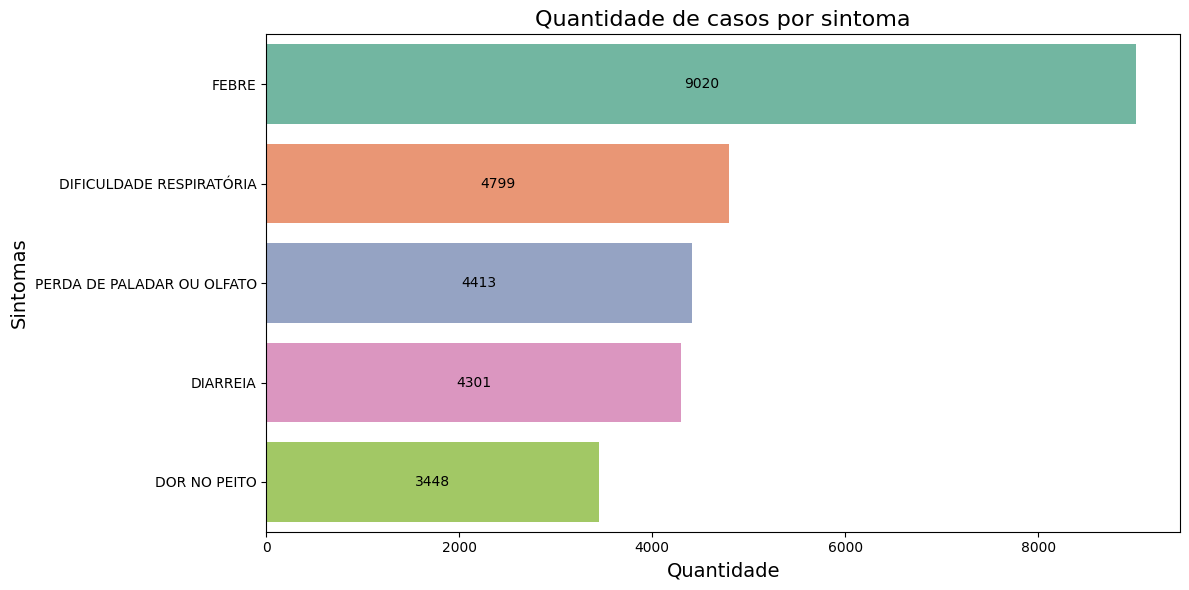

In [18]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='QUANTIDADE',
    y='SINTOMA',
    data=df_sintomas_positivos,
    palette='Set2'
)

# Adicionar valores no meio das barras
for bar in ax.patches:
    # Obter as coordenadas da barra
    value = bar.get_width()  # Valor da barra
    x = bar.get_x() + value / 2  # Posição central no eixo X
    y = bar.get_y() + bar.get_height() / 2  # Posição central no eixo Y

    # Adicionar o texto
    ax.text(x, y, f'{value:.0f}', ha='center', va='center', color='black', fontsize=10)

# Configurar título e rótulos
plt.title('Quantidade de casos por sintoma', fontsize=16)
plt.xlabel('Quantidade', fontsize=14)
plt.ylabel('Sintomas', fontsize=14)

# Exibir o gráfico
plt.tight_layout()
plt.show()


#### A consulta abaixo foi efeutada com a mesma lógica do pivot anterior, porém filtramos somente casos onde o resultado de Covid foi positivo ou negativo e algum sintoma clínico foi positivo.

In [19]:
query = """
SELECT
  RESULTADO_COVID,
  Sintoma,
  Codigo
FROM `tech-challenge-fase-3-442614.PNAD.PNAD_COVID_BASE`,
UNNEST([
  STRUCT('FEBRE' AS Sintoma, B0011 AS Codigo),
  STRUCT('DIFICULDADE RESPIRATÓRIA' AS Sintoma, B0014 AS Codigo),
  STRUCT('DOR NO PEITO' AS Sintoma, B0016 AS Codigo),
  STRUCT('PERDA DE PALADAR OU OLFATO' AS Sintoma, B00111 AS Codigo),
  STRUCT('DIARREIA' AS Sintoma, B00113 AS Codigo)
]) AS Unpivoted
WHERE
  RESULTADO_COVID IN (1, 2)

"""

query_job = client.query(query)

# Retornando os resultados como um DataFrame
results = query_job.to_dataframe()

tb_sintomas = spark.createDataFrame(results)

## Criando tabela temporaria para nossa consulta
tb_sintomas.createOrReplaceTempView("tb_sintomas")

In [20]:
consulta_sintomas = spark.sql('''
  SELECT
    C.DESCRICAO AS RESULTADO_COVID,
    B.RESPOSTA  AS POSSUI_SINTOMA,
    A.Sintoma,
    COUNT(a.Sintoma) AS QUANTIDADE
  FROM tb_sintomas a
    LEFT JOIN depara_resposta b
      ON a.Codigo = b.codigo
    LEFT JOIN depara_teste_covid c
      ON a.resultado_covid = c.codigo
  WHERE
    B.codigo IN (1)
  GROUP BY
    C.DESCRICAO,
    B.RESPOSTA,
    A.Sintoma
  ORDER BY RESULTADO_COVID DESC,QUANTIDADE DESC
''')


df_sintomas = consulta_sintomas.toPandas()


In [21]:
df_sintomas.head(10)

,RESULTADO_COVID,POSSUI_SINTOMA,Sintoma,QUANTIDADE
0,Positivo,Sim,FEBRE,1745
1,Positivo,Sim,PERDA DE PALADAR OU OLFATO,1652
2,Positivo,Sim,DIFICULDADE RESPIRATÓRIA,1055
3,Positivo,Sim,DOR NO PEITO,821
4,Positivo,Sim,DIARREIA,780
5,Negativo,Sim,FEBRE,1744
6,Negativo,Sim,DIFICULDADE RESPIRATÓRIA,919
7,Negativo,Sim,DIARREIA,684
8,Negativo,Sim,PERDA DE PALADAR OU OLFATO,632
9,Negativo,Sim,DOR NO PEITO,607


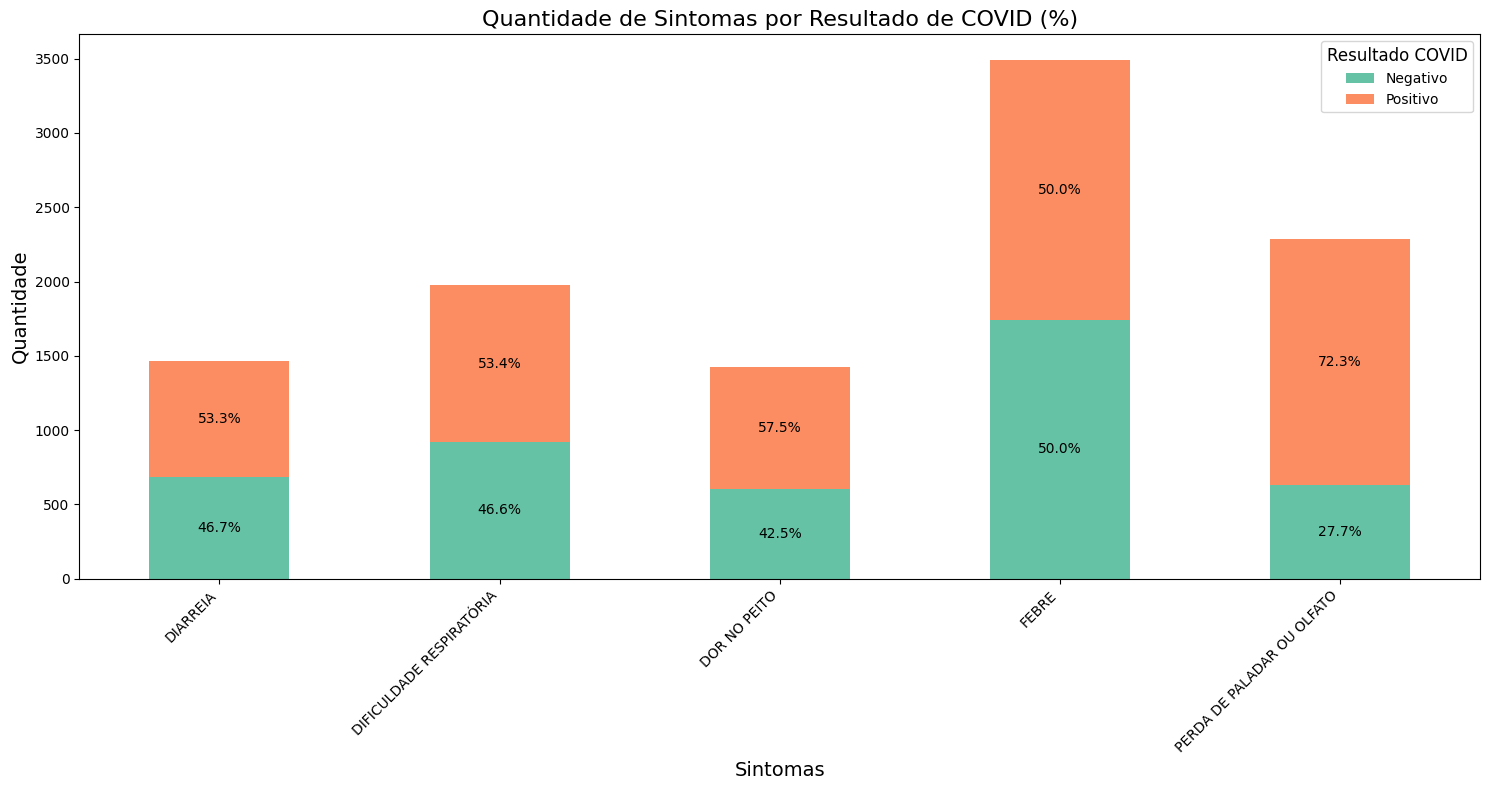

In [22]:
pivot_data = df_sintomas.pivot_table(
    index='Sintoma',
    columns='RESULTADO_COVID',
    values='QUANTIDADE',
    aggfunc='sum',
    fill_value=0
)

# Criar o gráfico de barras empilhadas
fig, ax = plt.subplots(figsize=(15, 8))
medium_colors = sns.color_palette("Set2", len(pivot_data.columns))

bars = pivot_data.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=medium_colors
)

# Adicionar os percentuais nas parcelas das barras
for i, col in enumerate(pivot_data.columns):
    cumulative_sum = pivot_data.iloc[:, :i].sum(axis=1)  # Soma cumulativa até a barra atual
    for j, value in enumerate(pivot_data[col]):
        percent = (value / pivot_data.iloc[j].sum()) * 100
        ax.text(
            x=j,
            y=cumulative_sum[j] + value / 2,  # Posição no meio da barra atual
            s=f'{percent:.1f}%',
            ha='center', va='center', fontsize=10, color='black'
        )

# Configurar título e legendas
ax.set_title('Quantidade de Sintomas por Resultado de COVID (%)', fontsize=16)
ax.set_xlabel('Sintomas', fontsize=14)
ax.set_ylabel('Quantidade', fontsize=14)
ax.legend(title='Resultado COVID', title_fontsize=12, fontsize=10)
plt.xticks(rotation=45, ha='right')

# Exibir o gráfico
plt.tight_layout()
plt.show()


#### Consulta criada para termos a distribuição de idade dos entrevistados

In [23]:
query = """
SELECT
  A002
  ,A005
  ,RESULTADO_COVID
FROM `tech-challenge-fase-3-442614.PNAD.PNAD_COVID_BASE`
"""

query_job = client.query(query)

# Retornando os resultados como um DataFrame
results = query_job.to_dataframe()

tb_populacao = spark.createDataFrame(results)

## Criando tabela temporaria para nossa consulta
tb_populacao.createOrReplaceTempView("tb_populacao")

In [24]:
consulta_populacao = spark.sql('''
  SELECT
     A.A002               AS IDADE
    ,B.escolaridade       AS ESCOLARIDADE
  FROM tb_populacao A
    LEFT JOIN depara_escolaridade B
      ON A.A005 = B.codigo
''')

df_populacao = consulta_populacao.toPandas()

In [25]:
df_populacao.head()

,IDADE,ESCOLARIDADE
0,91,Superior completo
1,78,Superior completo
2,84,Superior completo
3,80,Superior completo
4,86,Superior completo


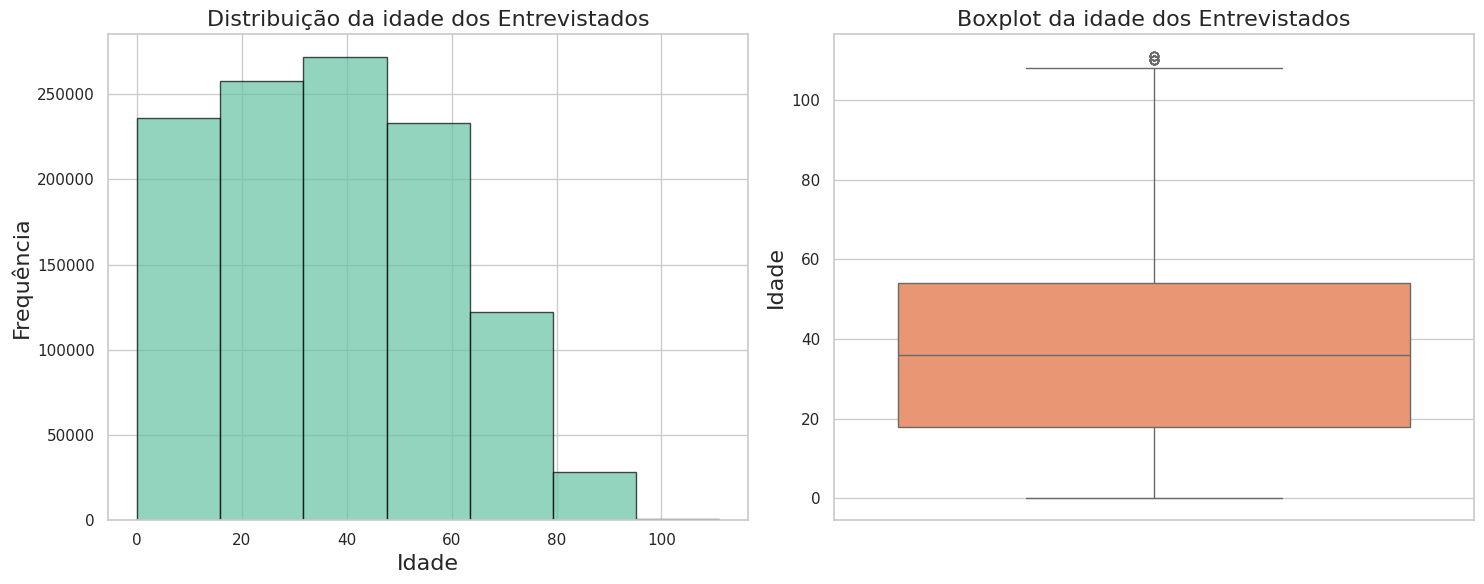

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
medium_colors = sns.color_palette("Set2")

# Histogram
axes[0].hist(df_populacao['IDADE'], bins=7, color=medium_colors[0], edgecolor='black', alpha=0.7)
axes[0].set_title('Distribuição da idade dos Entrevistados', fontsize=16)
axes[0].set_xlabel('Idade', fontsize=16)
axes[0].set_ylabel('Frequência', fontsize=16)

# Boxplot
sns.boxplot(y='IDADE', data=df_populacao, color=medium_colors[1], ax=axes[1])
axes[1].set_title('Boxplot da idade dos Entrevistados', fontsize=16)
axes[1].set_ylabel('Idade', fontsize=16)

plt.tight_layout()
plt.show()

#### A consulta abaixo filtra somente casos onde o entrevistado teve perda de olfato ou paladar, para termos uma analise da distribuição de idade dos pacientes que tiveram o sintoma positivo.

In [27]:
# query = """
# SELECT
#   RESULTADO_COVID,
#   Sintoma,
#   Codigo,
#   A002
# FROM `tech-challenge-fase-3-442614.PNAD.PNAD_COVID_BASE`,
# UNNEST([
#   STRUCT('FEBRE' AS Sintoma, B0011 AS Codigo),
#   STRUCT('DIFICULDADE RESPIRATÓRIA' AS Sintoma, B0014 AS Codigo),
#   STRUCT('DOR NO PEITO' AS Sintoma, B0016 AS Codigo),
#   STRUCT('PERDA DE PALADAR OU OLFATO' AS Sintoma, B00111 AS Codigo),
#   STRUCT('DIARREIA' AS Sintoma, B00113 AS Codigo)
# ]) AS Unpivoted
# WHERE
#   RESULTADO_COVID = 1 AND Codigo = 1 AND Sintoma = 'PERDA DE PALADAR OU OLFATO'
# """

query = """
SELECT
  A002    AS IDADE,
  B00111  AS PALADAR
FROM `tech-challenge-fase-3-442614.PNAD.PNAD_COVID_BASE`
  WHERE B00111 = 1
"""

query_job = client.query(query)

# Retornando os resultados como um DataFrame
tb_paladar = query_job.to_dataframe()

In [28]:
tb_paladar.head()

,IDADE,PALADAR
0,74,1
1,62,1
2,62,1
3,3,1
4,83,1


#### Selecionando a coluna idade e filtrando somente entrevistados que testaram positivo para a covid

In [29]:
query = """
SELECT
  RESULTADO_COVID,
  A002
FROM `tech-challenge-fase-3-442614.PNAD.PNAD_COVID_BASE`
WHERE
  RESULTADO_COVID = 1
"""

query_job = client.query(query)

# Retornando os resultados como um DataFrame
results = query_job.to_dataframe()

tb_populacao_covid_positivo = spark.createDataFrame(results)

## Criando tabela temporaria para nossa consulta
tb_populacao_covid_positivo.createOrReplaceTempView("tb_populacao_covid_positivo")

In [30]:
consulta_populacao_covid = spark.sql('''
  SELECT
    CASE
        WHEN A.A002 BETWEEN 0 AND 20      THEN    'FAIXA 0-20'
        WHEN A.A002 BETWEEN 21 AND 40     THEN    'FAIXA 21-40'
        WHEN A.A002 BETWEEN 41 AND 60     THEN    'FAIXA 41-60'
        WHEN A.A002 BETWEEN 61 AND 80     THEN    'FAIXA 61-80'
        WHEN A.A002 BETWEEN 81 AND 100    THEN    'FAIXA 81-100'
      ELSE 'VALIDAR'
      END FAIXA_IDADE
     ,COUNT(*) AS QUANTIDADE
  FROM tb_populacao_covid_positivo A
    WHERE A.A002 NOT BETWEEN 101 AND 130
  GROUP BY
     FAIXA_IDADE
''')

df_populacao_covid_positivo = consulta_populacao_covid.toPandas()

In [31]:
df_populacao_covid_positivo.head()

,FAIXA_IDADE,QUANTIDADE
0,FAIXA 61-80,3894
1,FAIXA 0-20,3888
2,FAIXA 81-100,499
3,FAIXA 21-40,12882
4,FAIXA 41-60,11749


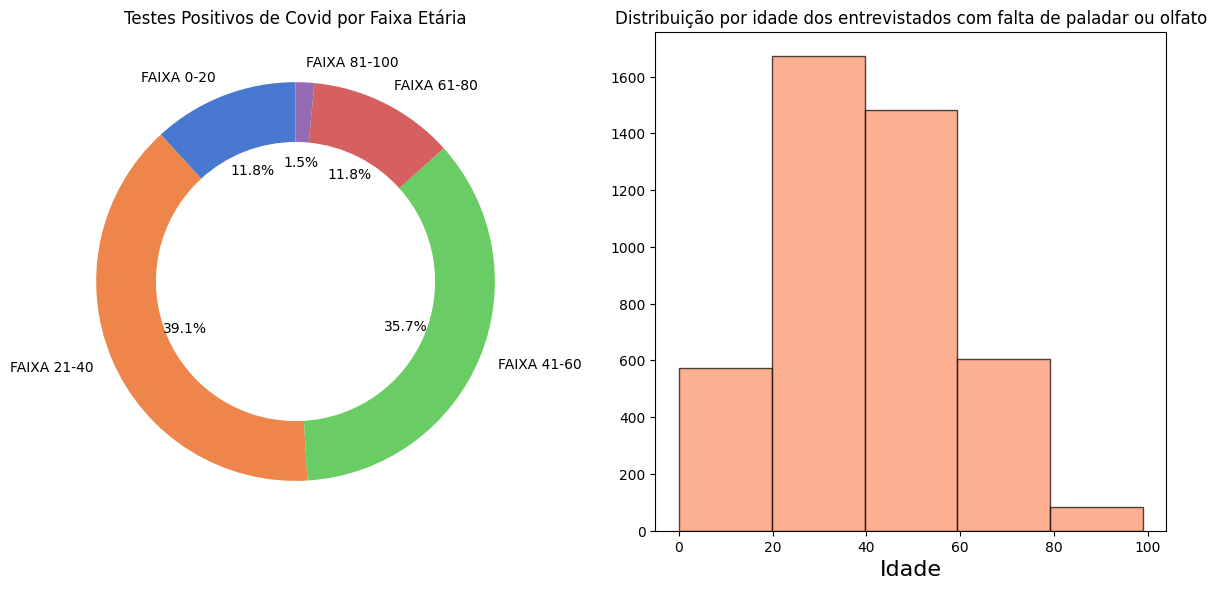

In [32]:
ordem_faixas = ["FAIXA 0-20", "FAIXA 21-40", "FAIXA 41-60", "FAIXA 61-80", "FAIXA 81-100"]

# Ordenando os DataFrames com base na faixa etária
df_populacao_covid_positivo = df_populacao_covid_positivo.set_index("FAIXA_IDADE").loc[ordem_faixas].reset_index()

# Gerando as cores da paleta 'medium_colors'
palette = sns.color_palette("muted", n_colors=len(ordem_faixas))
faixa_cores = dict(zip(ordem_faixas, palette))

# Extraindo as cores para cada gráfico
cores_positivo = [faixa_cores[faixa] for faixa in df_populacao_covid_positivo["FAIXA_IDADE"]]

# Dados para o gráfico de Testes Positivos
quantidades_positivo = df_populacao_covid_positivo["QUANTIDADE"]
faixa_idade_positivo = df_populacao_covid_positivo["FAIXA_IDADE"]


# Criando os gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico 1 - Testes Positivos
axes[0].pie(
    quantidades_positivo,
    labels=faixa_idade_positivo,
    colors=cores_positivo,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'width': 0.3}
)
axes[0].set_title("Testes Positivos de Covid por Faixa Etária")

# Gráfico 2 - Sintomas de Falta de Paladar
axes[1].hist(tb_paladar['IDADE'], bins=5, color=medium_colors[1], edgecolor='black', alpha=0.7)
axes[1].set_title('Distribuição por idade dos entrevistados com falta de paladar ou olfato')
axes[1].set_xlabel('Idade', fontsize=16)

# Ajustando e exibindo
plt.tight_layout()
plt.show()


## 3.0 Características econômicas, comportamento da população e condições hospitalares

#### Consulta para termos a quantidade de entrevistados por grau de escolaridade

In [33]:
consulta_escolaridade = spark.sql('''
  SELECT
    B.escolaridade       AS ESCOLARIDADE
    ,COUNT(*)            AS QUANTIDADE
  FROM tb_populacao A
    LEFT JOIN depara_escolaridade B
      ON A.A005 = B.codigo
  GROUP BY
    ESCOLARIDADE
''')

df_escolaridade = consulta_escolaridade.toPandas()

In [34]:
df_escolaridade.head()

,ESCOLARIDADE,QUANTIDADE
0,"Pós-graduação, mestrado ou doutorado",30290
1,Superior incompleto,59678
2,Fundamental incompleto,387986
3,Médio completo,256040
4,Fundamental completo,76092


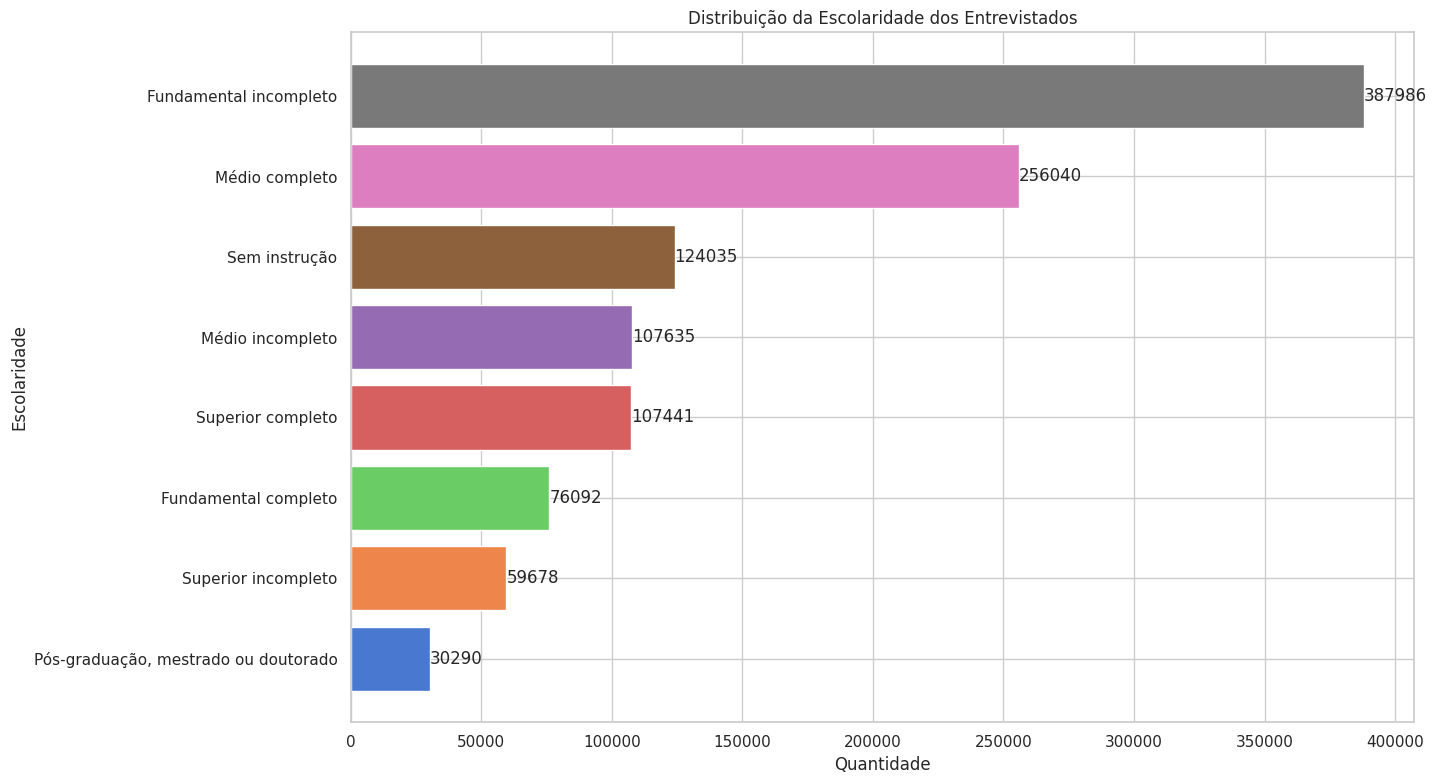

In [144]:
df_escolaridade = df_escolaridade.sort_values(by="QUANTIDADE", ascending=True)

# Criando a paleta de cores
palette = sns.color_palette("muted", n_colors=len(df_escolaridade))

# Criando o gráfico de barras horizontal
plt.figure(figsize=(14.5, 8))
bars = plt.barh(
    df_escolaridade["ESCOLARIDADE"],
    df_escolaridade["QUANTIDADE"],
    color=palette
)

# Adicionando rótulos de valores nas barras
for bar in bars:
    plt.text(
        bar.get_width() + 5,  # Posição do texto (levemente deslocada para direita)
        bar.get_y() + bar.get_height() / 2,  # Posição central na altura da barra
        str(int(bar.get_width())),  # Valor do rótulo
        va="center"  # Alinhamento vertical
    )

# Título e rótulos dos eixos
plt.title("Distribuição da Escolaridade dos Entrevistados")
plt.xlabel("Quantidade", fontsize=12)
plt.ylabel("Escolaridade", fontsize=12)

# Ajustando layout e exibindo o gráfico
plt.tight_layout()
plt.show()


#### Consulta para sabermos qual foi os locais com mais procura de atendimento

In [36]:
query = """
SELECT
  Local,
  COUNT(Codigo) AS Quantidade
FROM `tech-challenge-fase-3-442614.PNAD.PNAD_COVID_BASE`,
UNNEST([
  STRUCT('Pronto sococorro (SUS/UPA)' AS Local, B0042 AS Codigo),
  STRUCT('Hospital SUS' AS Local, B0043 AS Codigo),
  STRUCT('Hospital Privado ou Ligado às forças armadas' AS Local, B0046 AS Codigo)
]) AS Unpivoted
WHERE
  Codigo = 1
GROUP BY
  Local
"""

query_job = client.query(query)

# Retornando os resultados como um DataFrame
df_local = query_job.to_dataframe()

In [37]:
df_local

,Local,Quantidade
0,Hospital SUS,2124
1,Pronto sococorro (SUS/UPA),2419
2,Hospital Privado ou Ligado às forças armadas,1180


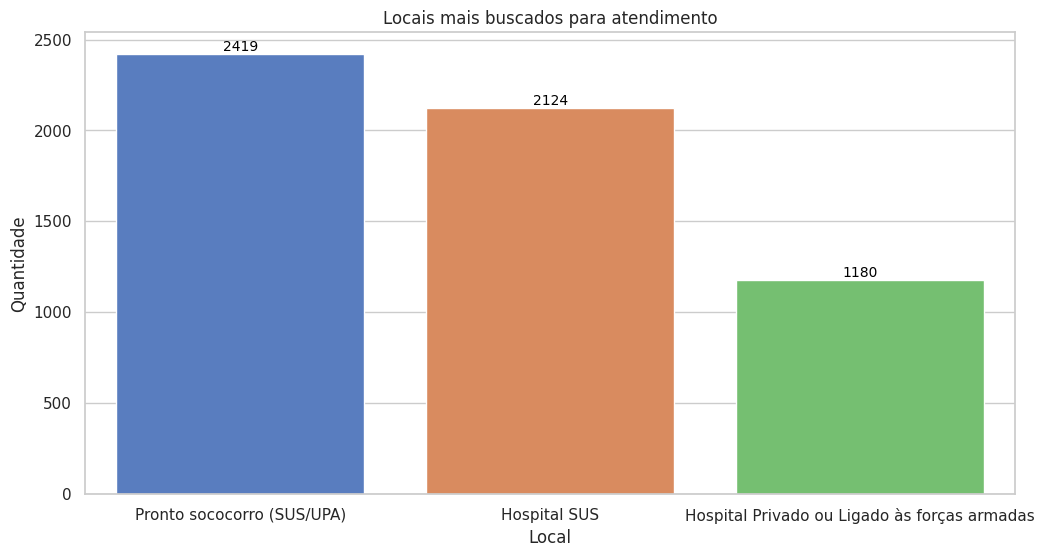

In [38]:
df_local = df_local.sort_values(by='Quantidade', ascending=False)

# Configuração do estilo
sns.set_theme(style="whitegrid")

# Criando o gráfico de barras com a paleta de cores "muted"
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_local, x='Local', y='Quantidade', palette='muted')

# Adicionando os valores no topo de cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black',
                xytext=(0, 5), textcoords='offset points')

# Adicionando título e rótulos
plt.title('Locais mais buscados para atendimento')
plt.ylabel('Quantidade', fontsize=12)

# Exibindo o gráfico
plt.show()


#### Consulta com a finalidade de sabermos quais são os cargos com mais funcionários

In [39]:
query = """
SELECT
  C007C
  ,count(*) as Quantidade
FROM `tech-challenge-fase-3-442614.PNAD.PNAD_COVID_BASE`
  WHERE C007C IS NOT NULL
GROUP BY
  C007C
"""

query_job = client.query(query)

# Retornando os resultados como um DataFrame
results = query_job.to_dataframe()

tb_trabalho = spark.createDataFrame(results)

## Criando tabela temporaria para nossa consulta
tb_trabalho.createOrReplaceTempView("tb_trabalho")

In [40]:
consulta_trabalho = spark.sql('''
  SELECT
    b.profissao
    ,a.Quantidade
  FROM tb_trabalho A
    INNER JOIN depara_profissoes B
      ON A.C007C = B.codigo
  WHERE
    B.codigo <> 36
  ORDER BY quantidade desc
  LIMIT 10
''')

df_trabalho = consulta_trabalho.toPandas()

In [41]:
df_trabalho.head()

,profissao,Quantidade
0,"Agricultor, criador de animais, pescador, silv...",45720
1,"Pedreiro, servente de pedreiro, pintor, eletri...",31140
2,"Empregado doméstico, diarista, cozinheiro (em ...",22285
3,"Outra profissão de nível superior (advogado, e...",22216
4,"Professor da educação infantil, de ensino fund...",19060


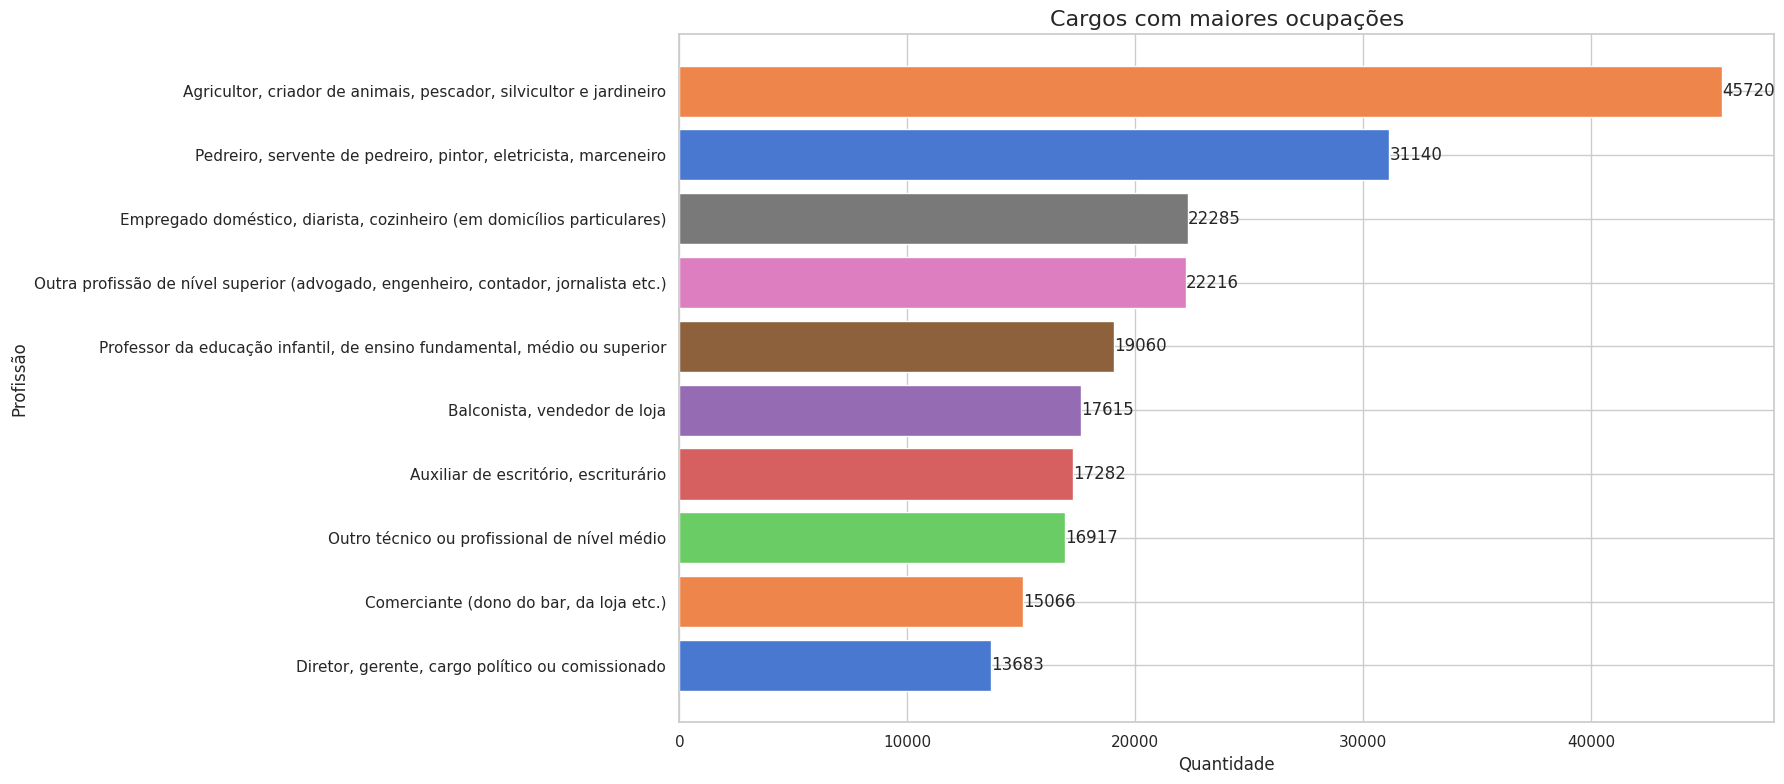

In [42]:
df_trabalho = df_trabalho.sort_values(by="Quantidade", ascending=True)

# Criando a paleta de cores
palette = sns.color_palette("muted", n_colors=len(df_escolaridade))

# Criando o gráfico de barras horizontal
plt.figure(figsize=(18, 8))
bars = plt.barh(
    df_trabalho["profissao"],
    df_trabalho["Quantidade"],
    color=palette
)

# Adicionando rótulos de valores nas barras
for bar in bars:
    plt.text(
        bar.get_width() + 5,  # Posição do texto (levemente deslocada para direita)
        bar.get_y() + bar.get_height() / 2,  # Posição central na altura da barra
        str(int(bar.get_width())),  # Valor do rótulo
        va="center"  # Alinhamento vertical
    )

# Título e rótulos dos eixos
plt.title("Cargos com maiores ocupações", fontsize=16)
plt.xlabel("Quantidade", fontsize=12)
plt.ylabel("Profissão", fontsize=12)

# Ajustando layout e exibindo o gráfico
plt.tight_layout()
plt.show()


#### Consulta para sabermos a faixa salarial dos funcionários

In [43]:
query = """
SELECT
    C01011
    ,COUNT(*)   AS QUANTIDADE
FROM `tech-challenge-fase-3-442614.PNAD.PNAD_COVID_BASE`
GROUP BY
     C01011
"""

query_job = client.query(query)

# Retornando os resultados como um DataFrame
df_faixa_salarial = query_job.to_dataframe()

tb_faixa_salarial = spark.createDataFrame(df_faixa_salarial)

## Criando tabela temporaria para nossa consulta
tb_faixa_salarial.createOrReplaceTempView("tb_faixa_salarial")

In [44]:
consulta_salario = spark.sql('''
  SELECT
    b.faixa_salarial as FAIXA_SALARIAL
    ,QUANTIDADE
  FROM tb_faixa_salarial A
    INNER JOIN depara_faixa_salarial B
      ON A.C01011 = B.codigo
''')

df_faixa_salario = consulta_salario.toPandas()

In [45]:
df_faixa_salario.head()

,FAIXA_SALARIAL,QUANTIDADE
0,0 - 100,2848
1,101 - 300,14405
2,301 - 600,30397
3,601 - 800,16718
4,801 - 1.600,189736


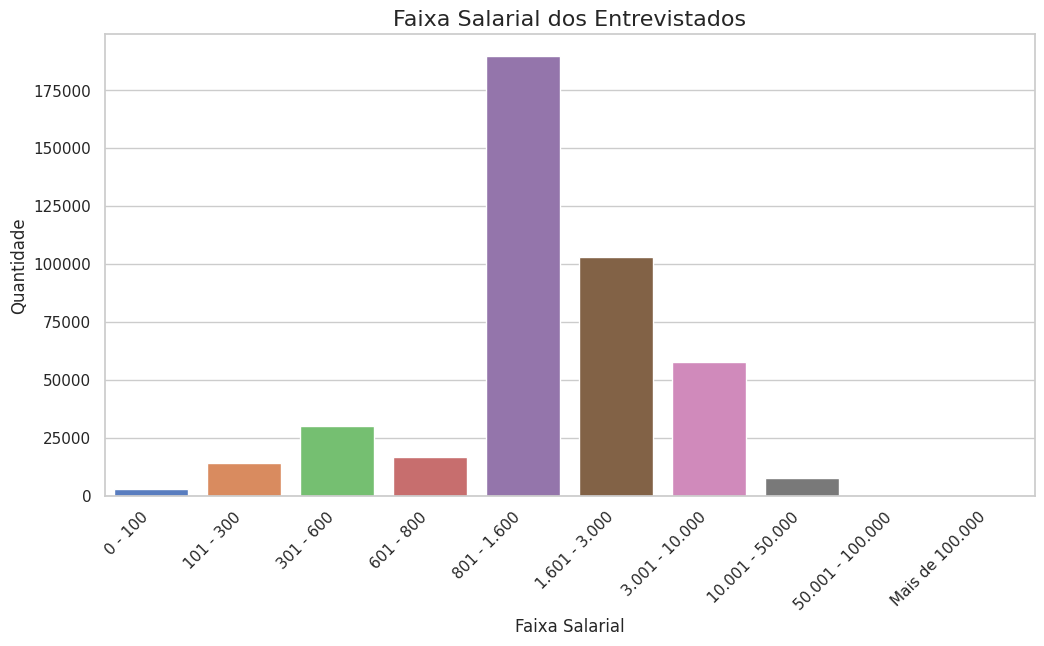

In [148]:
f_faixa_salario = df_faixa_salario.sort_values(by='QUANTIDADE', ascending=False)

# Configurando o estilo do gráfico
sns.set_theme(style="whitegrid")

# Criando o gráfico de barras com a paleta medium_colors
plt.figure(figsize=(12, 6))
sns.barplot(data=df_faixa_salario, x='FAIXA_SALARIAL', y='QUANTIDADE', palette='muted')

# Adicionando título e rótulos
plt.title('Faixa Salarial dos Entrevistados', fontsize=16)
plt.xlabel('Faixa Salarial', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)

# Rotacionando as legendas para ficarem legíveis
plt.xticks(rotation=45, ha="right")

# Exibindo o gráfico
plt.show()

#### Consulta efetuada para compararmos a quantidade de funcionários que trabalham presencial e home office

In [47]:
query = """
SELECT
  CASE
    WHEN C013 = 1 THEN 'REMOTO'
    ELSE 'PRESENCIAL'
  END TRABALHO
  ,count(*) as Quantidade
FROM `tech-challenge-fase-3-442614.PNAD.PNAD_COVID_BASE`
  WHERE C013 IN (1,2)
GROUP BY
  TRABALHO
"""

query_job = client.query(query)

# Retornando os resultados como um DataFrame
df_trabalho_remoto = query_job.to_dataframe()

In [48]:
df_trabalho_remoto

,TRABALHO,Quantidade
0,PRESENCIAL,14757
1,REMOTO,34021


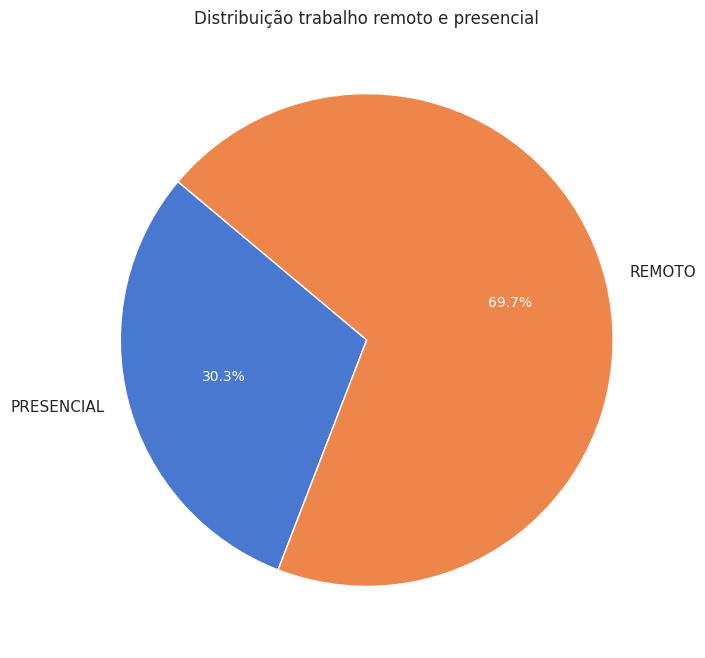

In [49]:
labels = df_trabalho_remoto['TRABALHO']
sizes = df_trabalho_remoto['Quantidade']
colors = sns.color_palette('muted', len(labels))  # Cores suaves

# Criando o gráfico de pizza
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors,
    textprops={'fontsize': 10})

# Ajustando as labels
for text in texts:
    text.set_fontsize(11)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)

# Título do gráfico
plt.title('Distribuição trabalho remoto e presencial')

# Exibindo o gráfico
plt.show()


#### Consulta com um agrupamento mensal da evolução quantitativa dos funcionários que trabalham presencialmente

In [50]:
query = """
SELECT
  MES,
  CASE
    WHEN C013 = 1 THEN 'REMOTO'
    ELSE 'PRESENCIAL'
  END TRABALHO
  ,count(*) as QUANTIDADE
FROM `tech-challenge-fase-3-442614.PNAD.PNAD_COVID_BASE`
  WHERE C013 IN (1,2)
GROUP BY
  TRABALHO,MES
ORDER BY
  MES
"""

query_job = client.query(query)

# Retornando os resultados como um DataFrame
df_trabalho_presencial_remoto = query_job.to_dataframe()

In [51]:
df_trabalho_presencial_remoto['MES'] = df_trabalho_presencial_remoto['MES'].astype('string')

In [52]:
df_trabalho_presencial = df_trabalho_presencial_remoto[df_trabalho_presencial_remoto['TRABALHO'] == 'PRESENCIAL']

In [92]:
meses_map = {
    '1': 'Janeiro', '2': 'Fevereiro', '3': 'Março', '4': 'Abril',
    '5': 'Maio', '6': 'Junho', '7': 'Julho', '8': 'Agosto',
    '9': 'Setembro', '10': 'Outubro', '11': 'Novembro', '12': 'Dezembro'
}


In [94]:
df_trabalho_presencial['NOME_MES'] = df_trabalho_presencial['MES'].map(meses_map)

In [95]:
df_trabalho_presencial.head()

,MES,TRABALHO,QUANTIDADE,NOME_MES
0,9,PRESENCIAL,5026,Setembro
2,10,PRESENCIAL,4913,Outubro
4,11,PRESENCIAL,4818,Novembro


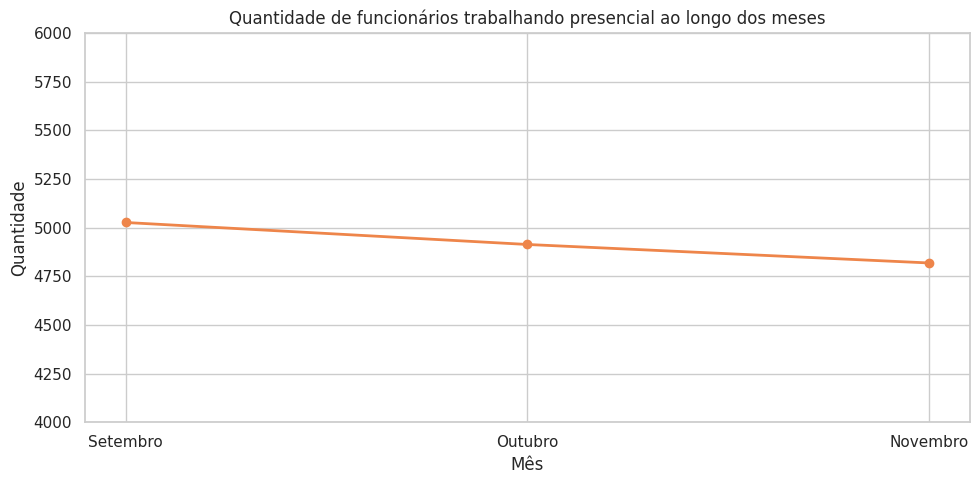

In [104]:
# Criando a paleta de cores
palette = sns.color_palette("muted", n_colors=3)

# Criando o gráfico de linhas
fig, ax1 = plt.subplots(figsize=(10, 5))

# Gráfico de linhas
ax1.plot(
    df_trabalho_presencial["NOME_MES"],
    df_trabalho_presencial["QUANTIDADE"],
    color=palette[1],  # Usando a cor da paleta
    marker='o',  # Marcadores nos pontos de dados
    linestyle='-',  # Linha sólida
    linewidth=2
)
# Adicionando título e rótulos
ax1.set_title("Quantidade de funcionários trabalhando presencial ao longo dos meses")
ax1.set_xlabel("Mês", fontsize=12)
ax1.set_ylabel("Quantidade", fontsize=12)


# Ajustando os limites do eixo y
ax1.set_ylim(4000,6000)  # Eixo Y do gráfico de linhas

# Ajustando o layout e exibindo o gráfico
plt.tight_layout()
plt.show()


#### Analise para sabermos se os casos de Covid aumentaram ao longo dos meses

In [55]:
query = """
SELECT
    MES
    ,COUNT(*)   AS QUANTIDADE
FROM `tech-challenge-fase-3-442614.PNAD.PNAD_COVID_BASE`
WHERE
  RESULTADO_COVID = 1
GROUP BY
     MES
ORDER BY MES
"""

query_job = client.query(query)

# Retornando os resultados como um DataFrame
temporal_resultado_covid = query_job.to_dataframe()


In [56]:
temporal_resultado_covid['MES'] = temporal_resultado_covid['MES'].astype('string')

In [110]:
temporal_resultado_covid['NOME_MES'] = temporal_resultado_covid['MES'].map(meses_map)

In [111]:
temporal_resultado_covid.head()

,MES,QUANTIDADE,NOME_MES
0,9,9519,Setembro
1,10,10951,Outubro
2,11,12452,Novembro


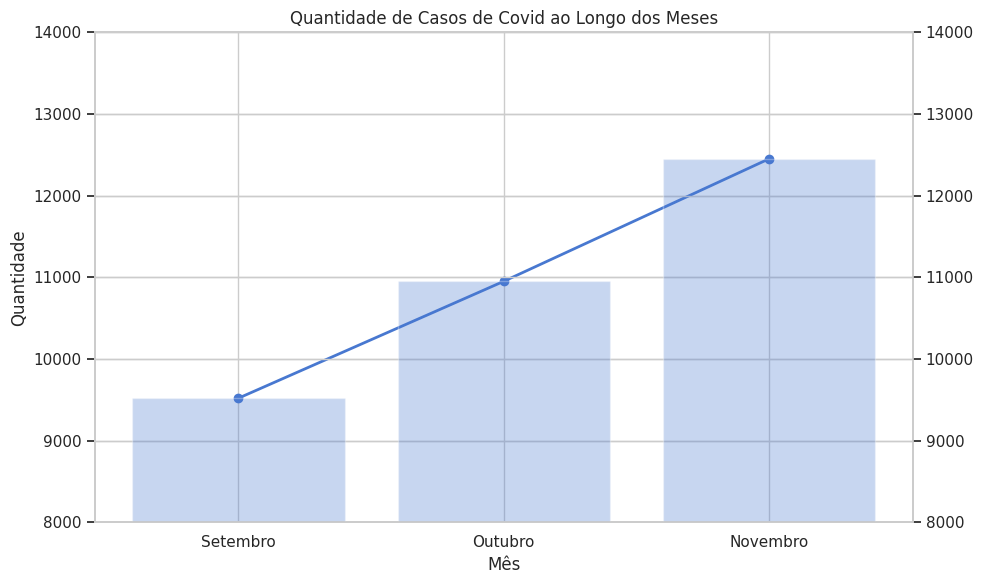

In [116]:
# Criando a paleta de cores
palette = sns.color_palette("muted", n_colors=3)

# Criando o gráfico de linhas
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de linhas
ax1.plot(
    temporal_resultado_covid["NOME_MES"],
    temporal_resultado_covid["QUANTIDADE"],
    color=palette[0],  # Usando a cor da paleta
    marker='o',  # Marcadores nos pontos de dados
    linestyle='-',  # Linha sólida
    linewidth=2
)

# Criando um segundo eixo y
ax2 = ax1.twinx()

# Gráfico de barras
ax2.bar(
    temporal_resultado_covid["NOME_MES"],
    temporal_resultado_covid["QUANTIDADE"],
    color=palette[0],
    alpha=0.3,  # Transparência para diferenciar do gráfico de linha
)

# Adicionando título e rótulos
ax1.set_title("Quantidade de Casos de Covid ao Longo dos Meses")
ax1.set_xlabel("Mês", fontsize=12)
ax1.set_ylabel("Quantidade", fontsize=12)


# Ajustando os limites do eixo y
ax1.set_ylim(8000, 14000)  # Eixo Y do gráfico de linhas
ax2.set_ylim(8000, 14000)  # Eixo Y do gráfico de barras

# Ajustando o layout e exibindo o gráfico
plt.tight_layout()
plt.show()


#### Consulta para analisarmos as internações ao longo dos meses

In [59]:
query = """
SELECT
  MES
  ,B005
  ,COUNT(*) AS QUANTIDADE
FROM `tech-challenge-fase-3-442614.PNAD.PNAD_COVID_BASE`
GROUP BY
  MES
  ,B005
"""

query_job = client.query(query)

# Retornando os resultados como um DataFrame
df_internacao = query_job.to_dataframe()

tb_internacao = spark.createDataFrame(df_internacao)

## Criando tabela temporaria para nossa consulta
tb_internacao.createOrReplaceTempView("tb_internacao")

In [60]:
consulta_uf = spark.sql('''
  SELECT
    MES,
    CASE
      WHEN b.atendimento = 'Sim' THEN 'INTERNADO'
      ELSE 'NÃO ATENDIDO'
    END SITUACAO
    ,a.QUANTIDADE
  FROM tb_internacao A
    INNER JOIN depara_atendimento B
      ON A.B005 = B.codigo
  WHERE
    B.atendimento in ('Sim','Não foi atendido')
''')

df_internacao = consulta_uf.toPandas()

In [120]:
df_internacao['MES'] = df_internacao['MES'].astype('string')

In [121]:
df_internacao['NOME_MES'] = df_internacao['MES'].map(meses_map)

In [128]:
df_internacao = df_internacao.sort_values(by='NOME_MES',ascending=False)

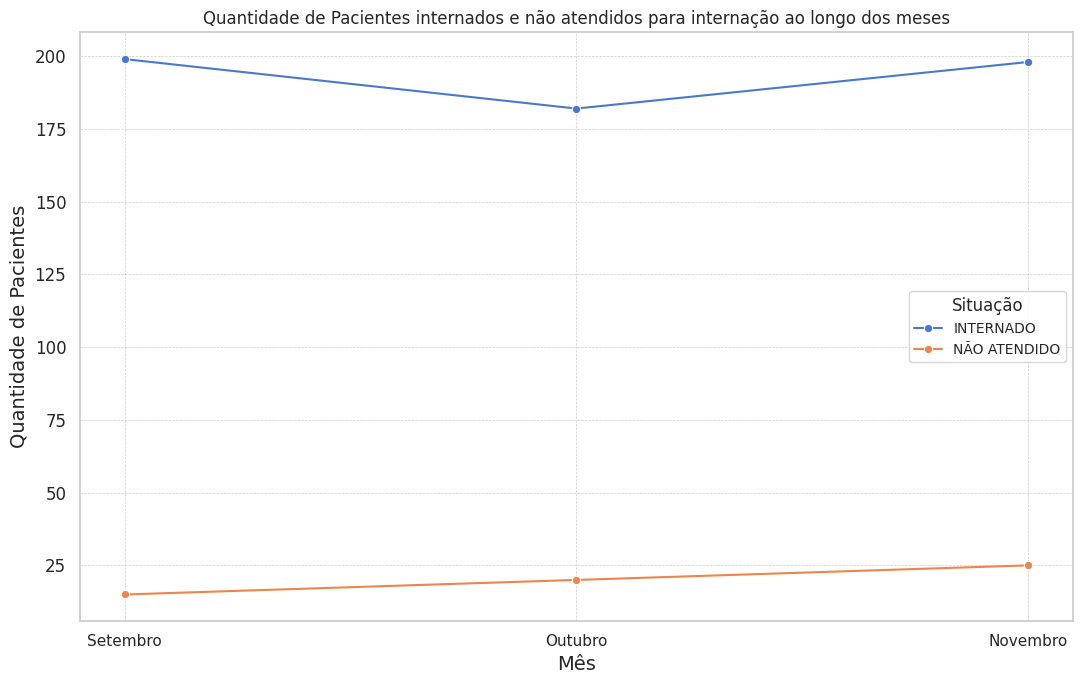

In [141]:
sns.set_theme(style="whitegrid")

# Criando o gráfico de linhas
plt.figure(figsize=(11, 7))
sns.lineplot(
    data=df_internacao,
    x='NOME_MES',
    y='QUANTIDADE',
    hue='SITUACAO',
    marker='o',
    palette='muted'
)

# Adicionando título e rótulos com fontes maiores
plt.title(
    'Quantidade de Pacientes internados e não atendidos para internação ao longo dos meses',
)
plt.xlabel('Mês', fontsize=14)
plt.ylabel('Quantidade de Pacientes', fontsize=14)

# Ajustando os ticks e rotacionando os meses para melhor visualização
plt.xticks(
    ticks=df_internacao['NOME_MES'].unique(),
    labels=df_internacao['NOME_MES'].unique()
)
plt.yticks(fontsize=12)

# Ajustando a legenda para melhor visualização
plt.legend(
    title='Situação',
    title_fontsize=12,
    fontsize=10
)

# Adicionando uma grade leve para facilitar a leitura
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

# Exibindo o gráfico
plt.tight_layout()
plt.show()


#### Consulta para filtrar pacientes que foram intubados durante a internação e apresentaram sintomas de problemas respiratórios

In [63]:
query = """
SELECT
  MES
  ,CASE
    WHEN B006 = 1 THEN 'ENTUBADO'
    ELSE 'NAO ENTUBADO'
  END ENTUBADO
  ,count(*) as QUANTIDADE
FROM `tech-challenge-fase-3-442614.PNAD.PNAD_COVID_BASE`
  WHERE B006 in (1,2) and B0014 = 1
GROUP BY
  B006
  ,MES
ORDER BY
  MES
"""

query_job = client.query(query)

# Retornando os resultados como um DataFrame
df_entubado = query_job.to_dataframe()

In [130]:
df_entubado['MES'] = df_entubado['MES'].astype('string')

In [131]:
df_entubado['NOME_MES'] = df_entubado['MES'].map(meses_map)

In [132]:
df_entubado = df_entubado.sort_values(by='NOME_MES',ascending=False)

In [133]:
df_entubado.head()

,MES,ENTUBADO,QUANTIDADE,NOME_MES
0,9,ENTUBADO,37,Setembro
1,9,NAO ENTUBADO,65,Setembro
2,10,NAO ENTUBADO,69,Outubro
3,10,ENTUBADO,28,Outubro
4,11,NAO ENTUBADO,77,Novembro


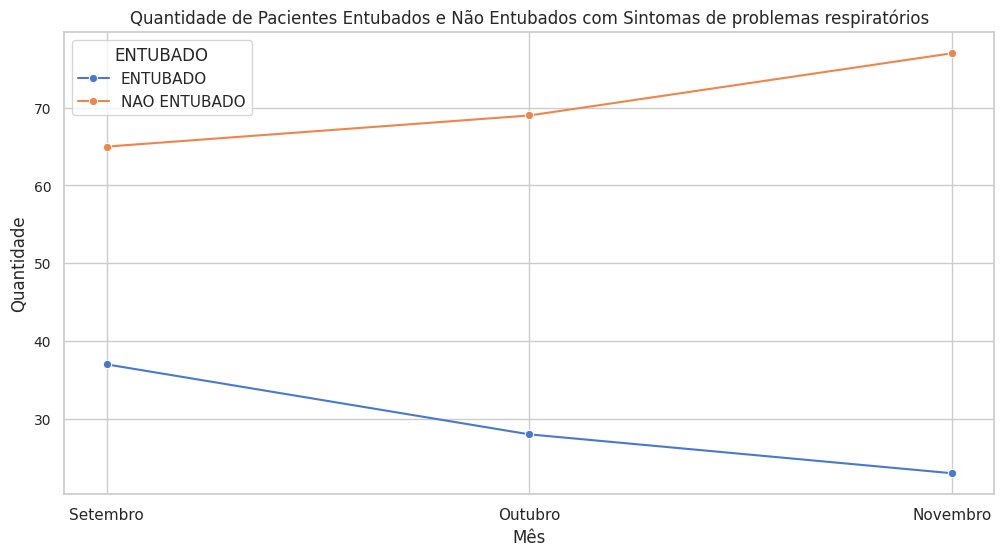

In [138]:
# Configurando o estilo do gráfico
sns.set_theme(style="whitegrid")

# Criando o gráfico de linhas
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_entubado, x='NOME_MES', y='QUANTIDADE', hue='ENTUBADO', marker='o', palette='muted')

# Adicionando título e rótulos
plt.title('Quantidade de Pacientes Entubados e Não Entubados com Sintomas de problemas respiratórios')
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)
plt.xticks(df_entubado['NOME_MES'].unique())
plt.yticks(fontsize=10)

# Exibindo o gráfico
plt.show()


#### Consulta criada para sabermos quais estados tem mais casos de covid, exportamos o arquivo pois o gráfico de mapa foi criado na ferramenta Power BI

In [66]:
# Query para selecionar dados da tabela
query = """
SELECT
    UF
    ,COUNT(*)   AS QUANTIDADE
FROM `tech-challenge-fase-3-442614.PNAD.PNAD_COVID_BASE`
WHERE
  RESULTADO_COVID = 1
GROUP BY
     UF
"""

query_job = client.query(query)

# Retornando os resultados como um DataFrame
resultado_covid_uf = query_job.to_dataframe()

tb_resultado_covid_uf = spark.createDataFrame(resultado_covid_uf)

## Criando tabela temporaria para nossa consulta
tb_resultado_covid_uf.createOrReplaceTempView("tb_resultado_covid_uf")

In [67]:
consulta_uf = spark.sql('''
  SELECT
    b.estado as ESTADO
    ,QUANTIDADE
  FROM tb_resultado_covid_uf A
    LEFT JOIN depara_uf B
      ON A.uf = B.codigo
''')

df_consulta_uf = consulta_uf.toPandas()

In [68]:
df_consulta_uf.head()

,ESTADO,QUANTIDADE
0,Bahia,1098
1,Piauí,1042
2,Mato Grosso do Sul,656
3,Paraíba,816
4,Alagoas,997


In [69]:
df_consulta_uf.to_csv('resultado_covid_uf.csv', index=False)

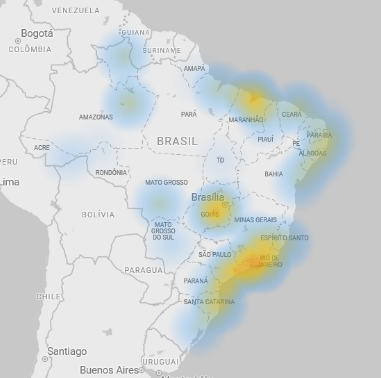

In [70]:
df_consulta_uf.sort_values(by='QUANTIDADE',ascending=False,inplace=True)

In [71]:
df_consulta_uf = df_consulta_uf.head(10)

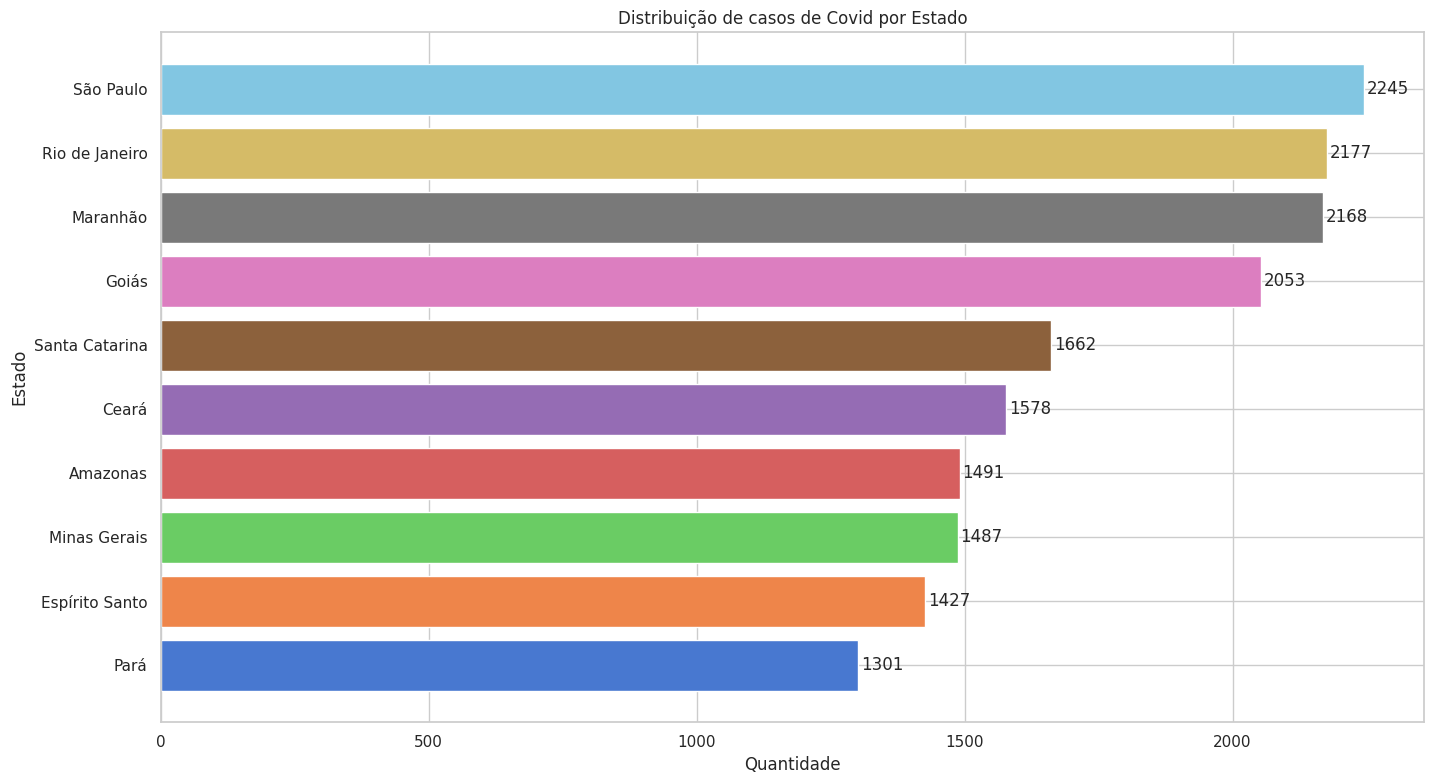

In [72]:
df_consulta_uf = df_consulta_uf.sort_values(by="QUANTIDADE", ascending=True)

# Criando a paleta de cores
palette = sns.color_palette("muted", n_colors=len(df_consulta_uf))

# Criando o gráfico de barras horizontal
plt.figure(figsize=(14.5, 8))
bars = plt.barh(
    df_consulta_uf["ESTADO"],
    df_consulta_uf["QUANTIDADE"],
    color=palette
)

# Adicionando rótulos de valores nas barras
for bar in bars:
    plt.text(
        bar.get_width() + 5,  # Posição do texto (levemente deslocada para direita)
        bar.get_y() + bar.get_height() / 2,  # Posição central na altura da barra
        str(int(bar.get_width())),  # Valor do rótulo
        va="center"  # Alinhamento vertical
    )

# Título e rótulos dos eixos
plt.title("Distribuição de casos de Covid por Estado")
plt.xlabel("Quantidade", fontsize=12)
plt.ylabel("Estado", fontsize=12)

# Ajustando layout e exibindo o gráfico
plt.tight_layout()
plt.show()
